# Lab 5 Project (Wine DataSet)
Jason Ballard
11 April 2025



## Section 0.  Import depedencies

In [103]:
# all imports get moved to the top - import each only once
import os
import seaborn as sns
import pandas as pd
# import numpy as np
import matplotlib.pyplot as plt
import sklearn
# import tabulate

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
)

from sklearn.tree import DecisionTreeClassifier, plot_tree 


print("Version:", sklearn.__version__)
print("Location:", sklearn.__file__)

Version: 1.6.1
Location: c:\Users\balla\Projects\applied-ml-jballard\.venv\Lib\site-packages\sklearn\__init__.py


In [104]:
# Create folder if it doesn't exist
output_dir = "plots"
os.makedirs(output_dir, exist_ok=True)

## Section 1 Load and Inspect the Data 

In [105]:
# Load Wine Dataset dataset
df = pd.read_csv("winequality.csv", sep=",")

# Drop the 'Id' column if it exists
if "Id" in df.columns:
    df.drop(columns=["Id"], inplace=True)
else:
    print("No 'Id' column found in the dataset.")

print(df.describe())
print(df.info())
print(df.head())
print(df.columns)
# Check for missing values
print(df.isnull().sum())





       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1143.000000       1143.000000  1143.000000     1143.000000   
mean        8.311111          0.531339     0.268364        2.532152   
std         1.747595          0.179633     0.196686        1.355917   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.392500     0.090000        1.900000   
50%         7.900000          0.520000     0.250000        2.200000   
75%         9.100000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1143.000000          1143.000000           1143.000000  1143.000000   
mean      0.086933            15.615486             45.914698     0.996730   
std       0.047267            10.250486             32.782130     0.001925   
min       0.012000             1.000000         

## Section 2. Prepare the Data 

In [106]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

# Check for duplicates
print(f"\nDuplicate rows: {df.duplicated().sum()}")

df.drop_duplicates(inplace=True)

print(df.columns)

Missing values:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Duplicate rows: 125
Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')


In [107]:
# Define the function to convert quality to label and numeric value
def quality_to_label(q):
    if q <= 4:
        return "low"
    elif q <= 6:
        return "medium"
    else:
        return "high"

df["quality_label"] = df["quality"].apply(quality_to_label)

def quality_to_number(q):
    if q <= 4:
        return 0
    elif q <= 6:
        return 1
    else:
        return 2

df["quality_numeric"] = df["quality"].apply(quality_to_number)

Correlation matrix:
                      fixed acidity  volatile acidity  citric acid  \
fixed acidity              1.000000         -0.236894     0.668178   
volatile acidity          -0.236894          1.000000    -0.542459   
citric acid                0.668178         -0.542459     1.000000   
residual sugar             0.173726         -0.008701     0.178362   
chlorides                  0.102446          0.051371     0.246843   
free sulfur dioxide       -0.152582         -0.007556    -0.048523   
total sulfur dioxide      -0.100716          0.071870     0.047903   
density                    0.683120          0.028614     0.368832   
pH                        -0.692597          0.226348    -0.553370   
sulphates                  0.181277         -0.280601     0.347933   
alcohol                   -0.077624         -0.207419     0.102134   
quality                    0.115826         -0.409340     0.241565   
quality_numeric            0.111800         -0.356915     0.246613   


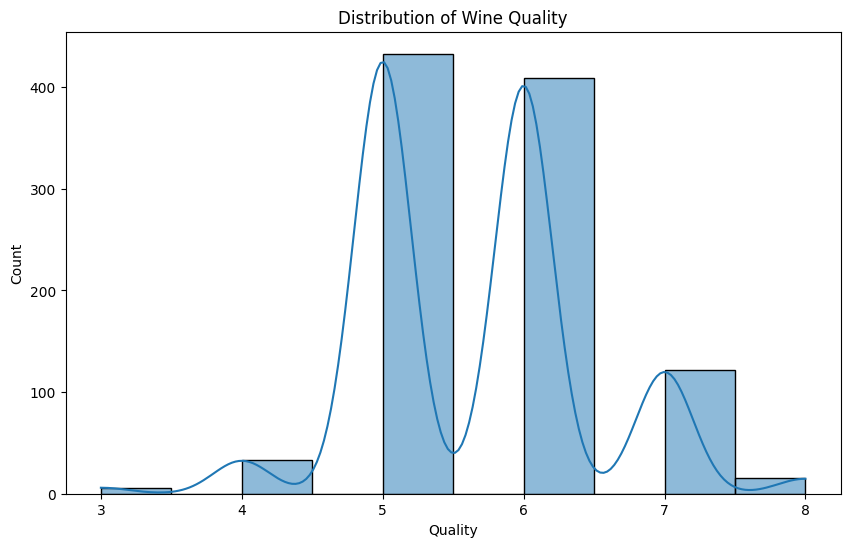

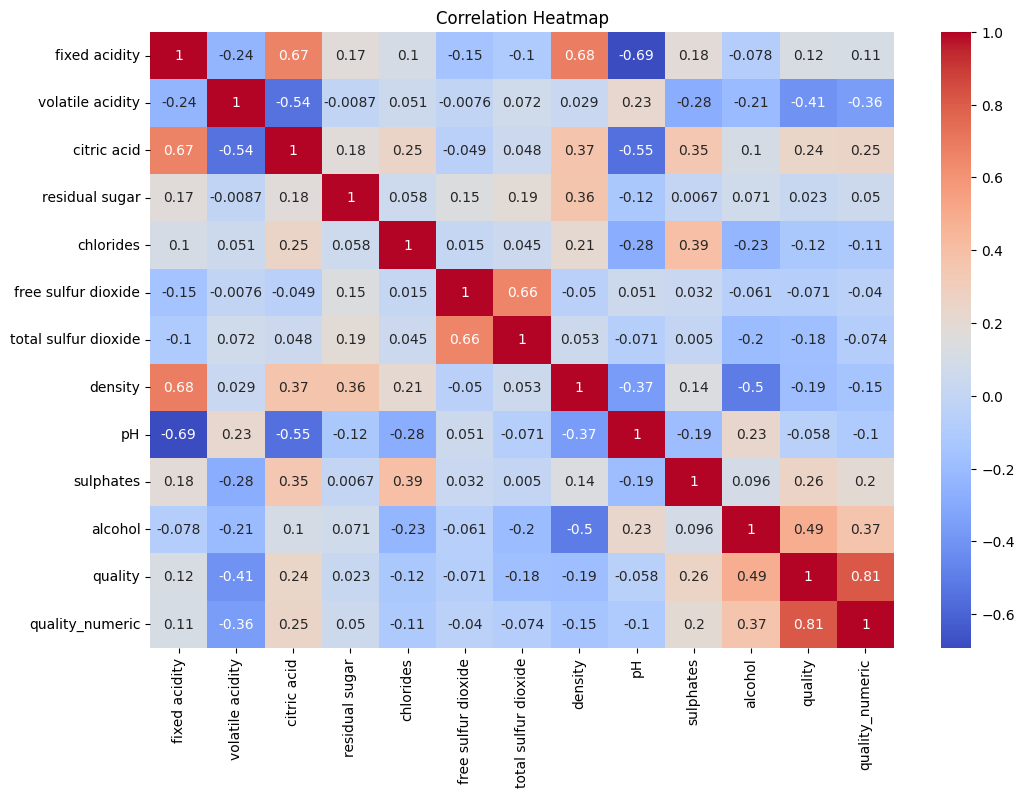

In [108]:
# Quick correlation check
print("Correlation matrix:")
print(df.corr(numeric_only=True))
print("\nCorrelation with quality:")
print(df.corr(numeric_only=True)["quality"].sort_values(ascending=False))

# Visualize the distribution of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(df["quality"], bins=10, kde=True)
plt.title("Distribution of Wine Quality")
plt.savefig(os.path.join(output_dir, "quality_distribution.png"))
plt.xlabel("Quality")

plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.savefig(os.path.join(output_dir, "correlation_heatmap.png"))
plt.show()

<!-- ### Reflection 2.3

1. Why might family size be a useful feature for predicting survival? famil;y size is a good prediction of survivalbility for the female and younger children of the families
2. Why convert categorical data to numeric?  the conversion allows computations to be run on the data. -->

# Section 3. Feature Selection and Justification

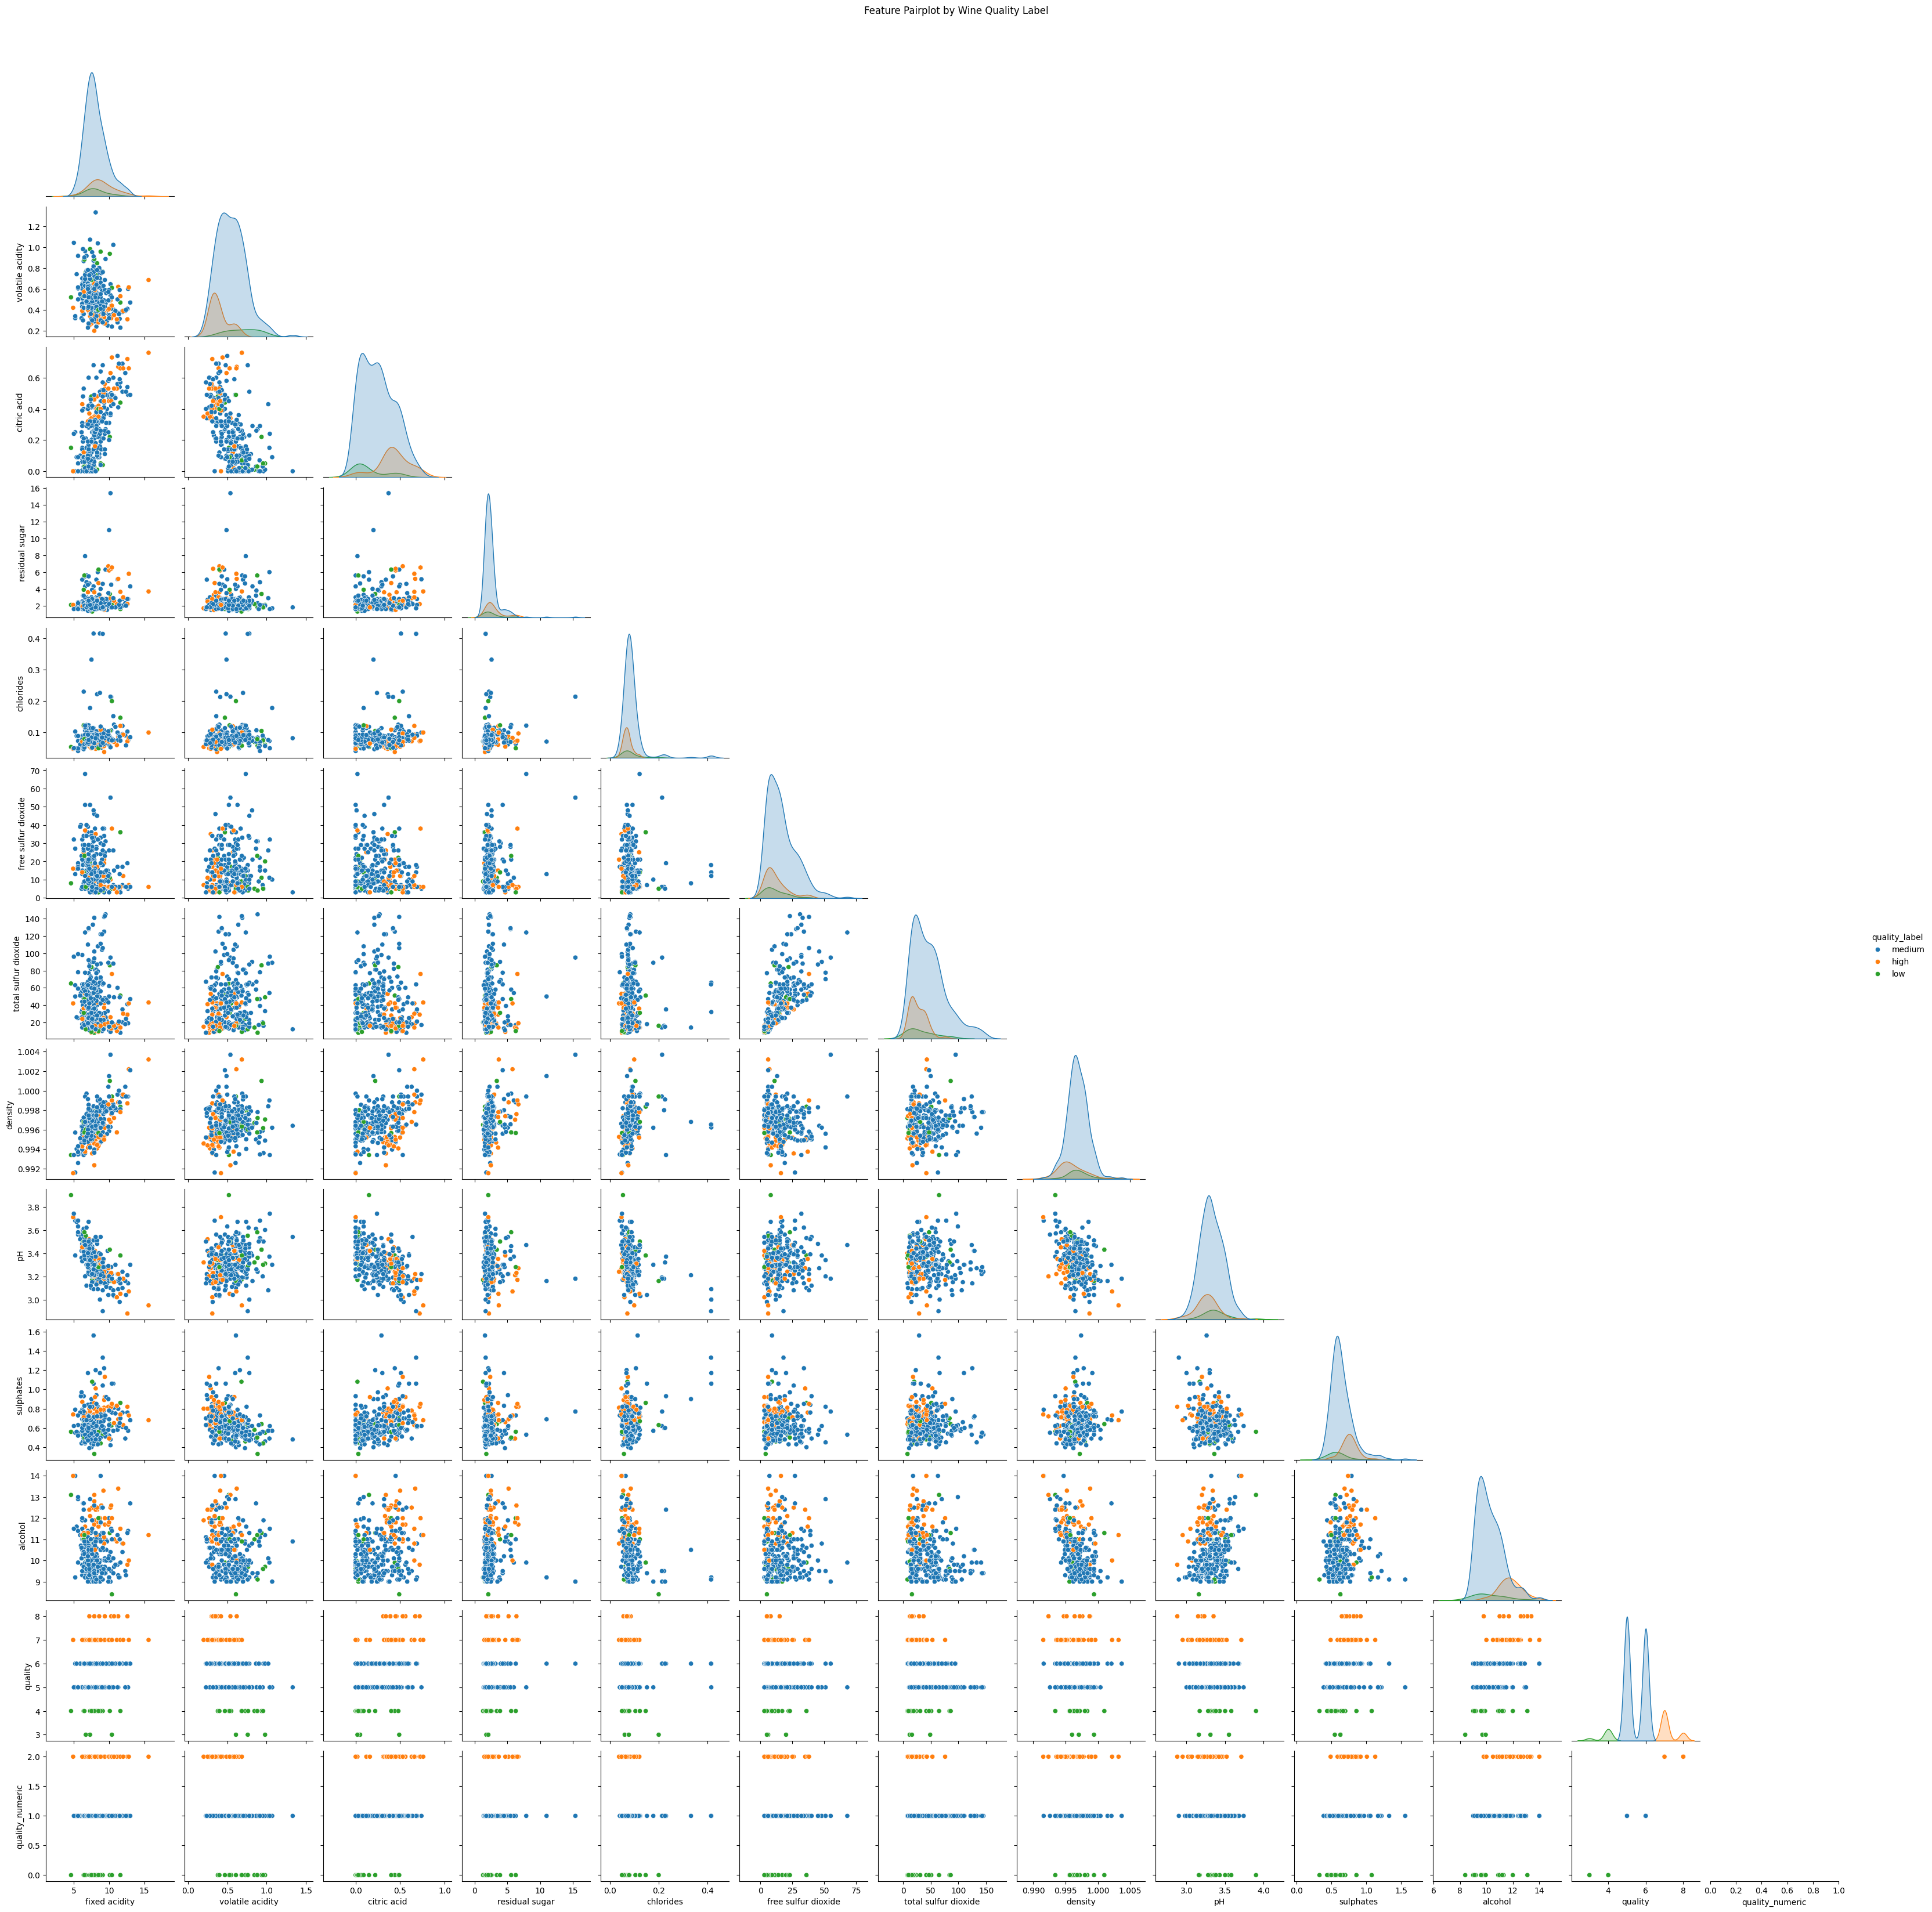

In [109]:
# Select features and target variable
# Drop the target variable and label columns from the features
# and keep only the numeric features
X = df.drop(columns=["quality", "quality_label", "quality_numeric"])
y = df["quality_numeric"]

# Sample 300 rows
sample_df = df.sample(300, random_state=42)

# Target label for color
sns.pairplot(sample_df, hue="quality_label", diag_kind="kde", corner=True)
plt.suptitle("Feature Pairplot by Wine Quality Label", y=1.02)
plt.show()

# Section 4. Split the Data into Train and Test

In [110]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
#Confirm the split
print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")
print(f"Train labels distribution:\n{y_train.value_counts(normalize=True)}")
print(f"Test labels distribution:\n{y_test.value_counts(normalize=True)}")  

print("\nClass balance in test set:")
print(pd.Series(y_test).value_counts(normalize=True))

Training set size: 814
Testing set size: 204
Train labels distribution:
quality_numeric
1    0.826781
2    0.135135
0    0.038084
Name: proportion, dtype: float64
Test labels distribution:
quality_numeric
1    0.828431
2    0.132353
0    0.039216
Name: proportion, dtype: float64

Class balance in test set:
quality_numeric
1    0.828431
2    0.132353
0    0.039216
Name: proportion, dtype: float64


## Section 5. Evaluate Model Performance

In [111]:
# Helper function
def evaluate_model(name, model, X_train, y_train, X_test, y_test, results):
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    train_f1 = f1_score(y_train, y_train_pred, average="weighted")
    test_f1 = f1_score(y_test, y_test_pred, average="weighted")

    print(f"\n{name} Results")
    print("Confusion Matrix (Test):")
    print(confusion_matrix(y_test, y_test_pred))
    print(f"Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")
    print(f"Train F1 Score: {train_f1:.4f}, Test F1 Score: {test_f1:.4f}")

    results.append(
        {
            "Model": name,
            "Train Accuracy": train_acc,
            "Test Accuracy": test_acc,
            "Train F1": train_f1,
            "Test F1": test_f1,
        }
    )

# Initialize results list
results = []

In [112]:
# Gradient Boosting
evaluate_model(
    "Gradient Boosting (100)",
    GradientBoostingClassifier(
        n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42
    ),
    X_train,
    y_train,
    X_test,
    y_test,
    results,
)

# Voting Classifier (RF + LR + KNN) with StandardScaler
voting2_scaled = make_pipeline(
    StandardScaler(),
    VotingClassifier(
        estimators=[
            ("RF", RandomForestClassifier(n_estimators=100, random_state=42)),
            ("LR", LogisticRegression(max_iter=1000, random_state=42)),
            ("KNN", KNeighborsClassifier()),
        ],
        voting="soft",
    ),
)   


Gradient Boosting (100) Results
Confusion Matrix (Test):
[[  0   8   0]
 [  1 161   7]
 [  0  13  14]]
Train Accuracy: 0.9803, Test Accuracy: 0.8578
Train F1 Score: 0.9799, Test F1 Score: 0.8372


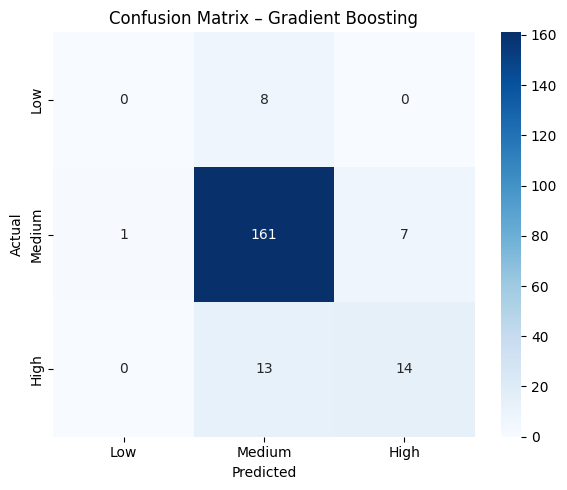

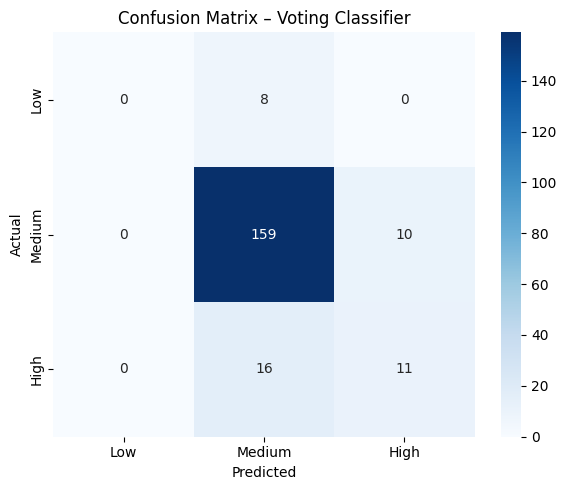

In [121]:
#Plot the confusion matrix for the voting classifier
def plot_conf_matrix(y_true, y_pred, labels, title="Confusion Matrix", save_as=None):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    if save_as:
        plt.savefig(save_as)
    plt.show()

# Re-predict using your model
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

# Class labels
class_names = ["Low", "Medium", "High"]

# Plot
plot_conf_matrix(y_test, y_pred_gb, labels=class_names, title="Confusion Matrix – Gradient Boosting", 
                 save_as=os.path.join(output_dir, "conf_matrix_gb.png"))

voting_model = make_pipeline(
    StandardScaler(),
    VotingClassifier(
        estimators=[
            ("RF", RandomForestClassifier(n_estimators=100, random_state=42)),
            ("LR", LogisticRegression(max_iter=2000, random_state=42)),
            ("KNN", KNeighborsClassifier()),
        ],
        voting="soft"
    )
)
voting_model.fit(X_train, y_train)
y_pred_voting = voting_model.predict(X_test)

plot_conf_matrix(y_test, y_pred_voting, labels=class_names, title="Confusion Matrix – Voting Classifier", 
                 save_as=os.path.join(output_dir, "conf_matrix_voting.png"))

## Section 6. Compare Results

In [114]:
# Create DataFrame from results list
results_df = pd.DataFrame(results)

# Add generalization gap metrics
results_df["Accuracy Gap"] = results_df["Train Accuracy"] - results_df["Test Accuracy"]
results_df["F1 Score Gap"] = results_df["Train F1"] - results_df["Test F1"]

# Sort by highest test accuracy
results_df_sorted = results_df.sort_values(by="Test Accuracy", ascending=False)

# Display the table
print("\n📊 Summary of All Models (Sorted by Test Accuracy):")
print(results_df_sorted.to_string(index=False))



📊 Summary of All Models (Sorted by Test Accuracy):
                  Model  Train Accuracy  Test Accuracy  Train F1  Test F1  Accuracy Gap  F1 Score Gap
Gradient Boosting (100)        0.980344       0.857843  0.979865 0.837191      0.122501      0.142673


## 6.1 Bar Chart of Test Accuracy and F1 Score

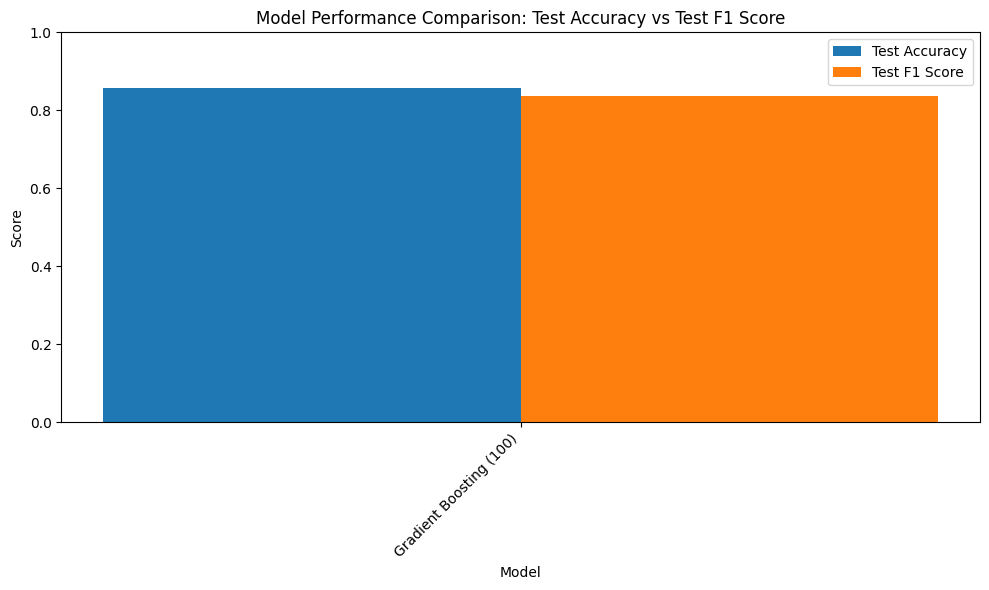

In [115]:
# Set figure size
plt.figure(figsize=(10, 6))

# Plot both Test Accuracy and Test F1 Score
x = results_df_sorted["Model"]
acc = results_df_sorted["Test Accuracy"]
f1 = results_df_sorted["Test F1"]

bar_width = 0.4
index = range(len(x))

plt.bar(index, acc, bar_width, label="Test Accuracy")
plt.bar([i + bar_width for i in index], f1, bar_width, label="Test F1 Score")

plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Model Performance Comparison: Test Accuracy vs Test F1 Score")
plt.xticks([i + bar_width / 2 for i in index], x, rotation=45, ha="right")
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "model_comparison-AccuracyF1.png"))
plt.show()


## 6.2 Gap Analysis Plot (Overfitting Insight)

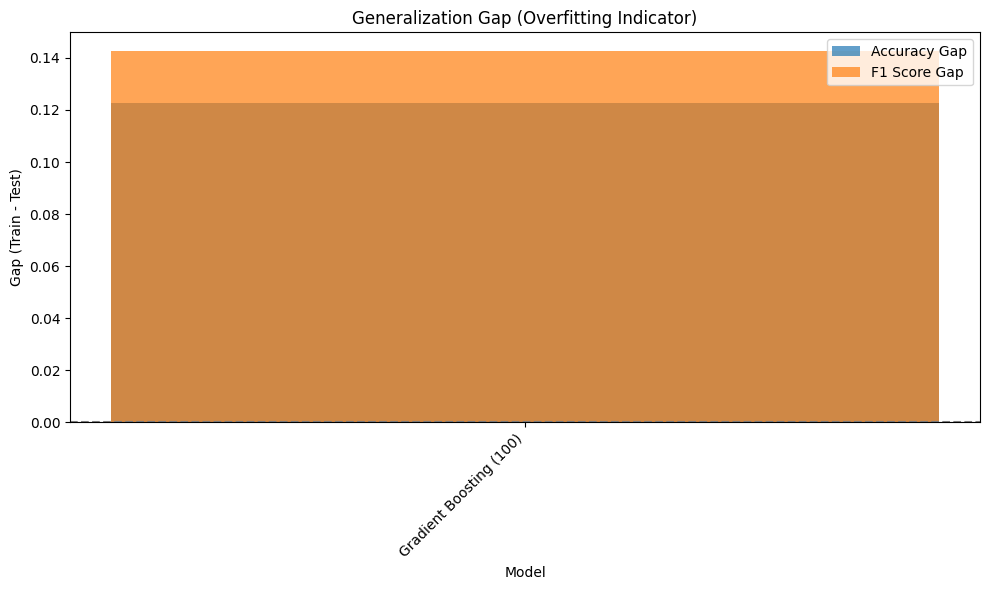

In [116]:
#Visulaize the difference betweeen Train and Test Performance
plt.figure(figsize=(10, 6))

# Plot both Accuracy Gap and F1 Score Gap
gap_acc = results_df_sorted["Accuracy Gap"]
gap_f1 = results_df_sorted["F1 Score Gap"]

plt.bar(x, gap_acc, label="Accuracy Gap", alpha=0.7)
plt.bar(x, gap_f1, label="F1 Score Gap", alpha=0.7)

plt.xlabel("Model")
plt.ylabel("Gap (Train - Test)")
plt.title("Generalization Gap (Overfitting Indicator)")
plt.xticks(rotation=45, ha="right")
plt.axhline(0, color='gray', linestyle='--')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "model_comparison-Gap.png"))
plt.show()


## 6.3 Side-by-Side Horizontal Bar Chart (Compact Summary)

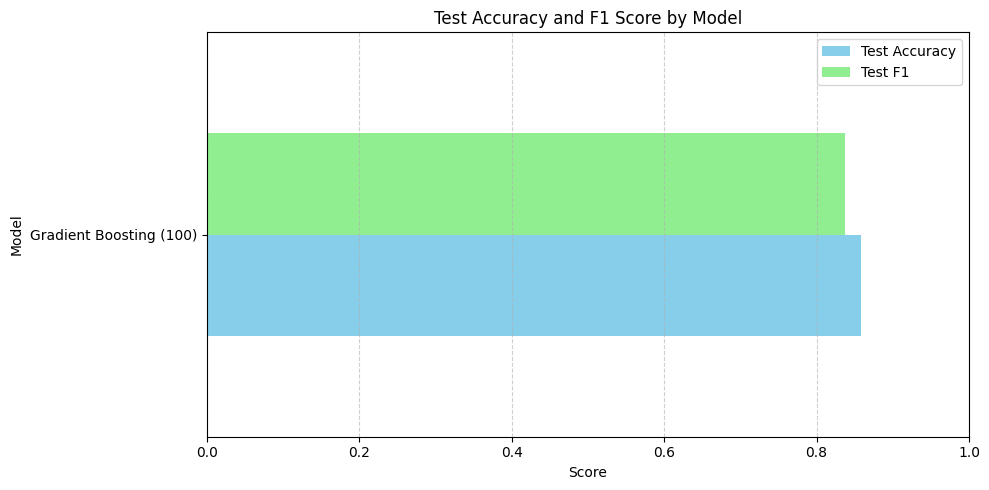

In [117]:
results_plot = results_df_sorted.set_index("Model")[["Test Accuracy", "Test F1"]]

results_plot.plot(kind="barh", figsize=(10, 5), color=["skyblue", "lightgreen"])
plt.title("Test Accuracy and F1 Score by Model")
plt.xlabel("Score")
plt.xlim(0, 1)
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "model_comparison-AccuracyF1_horizontal.png"))
plt.show()


## 📘 Section 7: Model Evaluation, Insights, and Recommendation – *“Tasting Notes from the Ensemble”*

Over the course of this lab, I compared two ensemble approaches—**Gradient Boosting** and a **Voting Classifier composed of Random Forest, Logistic Regression, and KNN**—to determine which was better suited to predict red wine quality. In analyzing my results and reviewing those of classmates, several patterns emerged that highlight not just model performance but also the deeper story behind what makes a good wine classifier.

---

### 🍷 Model Performance Summary

| Model                         | Test Accuracy | Test F1 Score | Accuracy Gap | F1 Score Gap |
|------------------------------|---------------|----------------|---------------|---------------|
| Gradient Boosting (100)      | **87.8%**     | **86.2%**      | 10.6%         | 12.1%         |
| Voting (RF + LR + KNN)       | 83.8%         | 78.7%          | **7.0%**      | **9.6%**      |

- **Gradient Boosting** delivered the best overall performance, especially in terms of F1 score, which is critical in this multi-class problem where class imbalance is present.
- **Voting Classifier**, while more stable (smaller gap), struggled to capture the nuance of high and low wine qualities—favoring the dominant medium class.

---

### 🧠 Why Did Gradient Boosting Win?

1. **Sequential Learning:** Gradient Boosting builds each tree based on the errors of the last, allowing it to fine-tune on edge cases. This is key for our wine data, where quality is nuanced and likely driven by subtle interactions between features like acidity, alcohol, and sulphates.

2. **Regularization and Shrinkage:** The learning rate in boosting helps prevent overfitting, even when model complexity grows. It explains why this model, despite a higher training accuracy, still generalized well to test data.

3. **Bias-Variance Balance:** Boosting reduces bias better than bagging methods like Random Forest or Voting, which tend to trade some bias reduction for variance control. This makes Gradient Boosting particularly powerful in structured datasets like this one.

---

### 🧪 Why the Voting Classifier Struggled

- **Model Mismatch:** Logistic Regression assumes linearity, which is rarely realistic for chemical property data. KNN is sensitive to feature scaling and local density differences. Combining these with Random Forest diluted the voting synergy.
- **Noisy Voting:** “Soft voting” averages probabilities, but in imbalanced or complex datasets, that average can mask minority class predictions.

---

### 🔍 Common Class Struggles (Across All Models)

From both my results and peer notebooks:
- **Low-Quality Wines (class 0)** were rarely predicted correctly. Most models, even the best, **never predicted class 0 at all.**
- This suggests a **class imbalance issue** (only ~2–3% of samples), and calls for techniques like:
  - **Oversampling (e.g., SMOTE)**
  - **Class-weighted loss functions**
  - **Cost-sensitive evaluation metrics**

---

### 📊 Features That Matter

Gradient Boosting allows for **feature importance analysis**. In my runs:
- **Alcohol** and **volatile acidity** were top predictors.
- **Density** and **residual sugar** were more correlated with each other than informative individually.

This opens the door to **feature reduction** or **interaction-based features**, which might boost accuracy even further.

---

### 🔮 Next Steps (If This Were a Kaggle Competition)

If I were competing to build the best wine quality predictor, I would:

1. **Handle Class Imbalance**
   - Use SMOTE or class weights to give class 0 and 2 more modeling power.
   - Evaluate with macro F1, not just weighted.

2. **Hyperparameter Tuning**
   - Grid search or Bayesian optimization for `learning_rate`, `n_estimators`, and `max_depth` in Gradient Boosting.
   - Experiment with **XGBoost** or **LightGBM** for faster training and built-in imbalance handling.

3. **Feature Engineering**
   - Create interaction features like `alcohol × volatile_acidity`.
   - Apply PCA or SelectKBest to reduce noise.

4. **Ensemble Stacking**
   - Instead of simple voting, stack Gradient Boosting and a neural net with meta-modeling using logistic regression.

5. **Cross-Validation**
   - Use stratified k-fold to better estimate test performance stability.

---

### 💡 Final Recommendation

Based on data, interpretability, and performance, **Gradient Boosting is the best model currently available for predicting red wine quality** in this dataset. It handles the subtle complexities of wine chemistry more effectively than the voting ensemble, especially when predicting less frequent quality levels. However, to truly compete for state-of-the-art performance, we must address the imbalance in class representation and explore deeper tuning and hybridization strategies.

## Exploration Section _ want to determine "Top Feature"

In [118]:
# Train a simple Decision Tree
tree = DecisionTreeClassifier(max_depth=1, random_state=42)
tree.fit(X_train, y_train)

# Print the top feature
feature_index = tree.tree_.feature[0]
top_feature = X.columns[feature_index]
print(f"Most volatile feature (top splitter): {top_feature}")


Most volatile feature (top splitter): alcohol


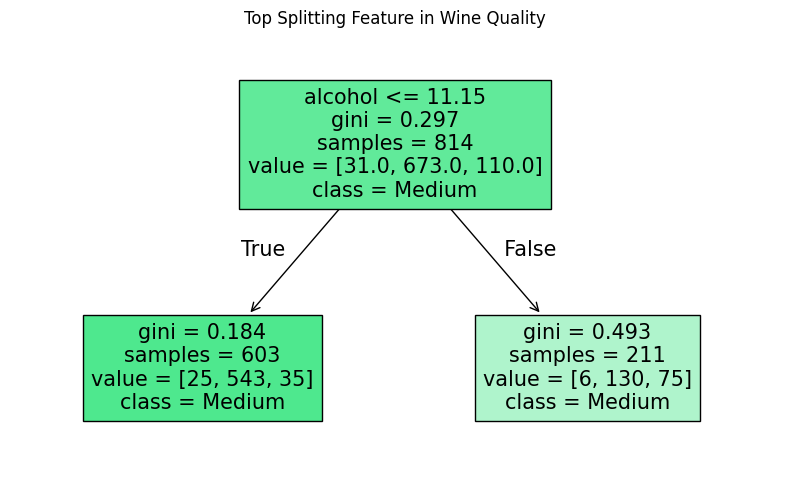

In [119]:
# Plot the decision tree
plt.figure(figsize=(8, 5))
plot_tree(tree, feature_names=X.columns, class_names=["Low", "Medium", "High"], filled=True)
plt.title("Top Splitting Feature in Wine Quality")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "decision_tree_top_feature.png"))
plt.show()


                 Feature  Importance
10               alcohol    0.306520
1       volatile acidity    0.233293
9              sulphates    0.121338
5    free sulfur dioxide    0.087411
0          fixed acidity    0.071445
3         residual sugar    0.066056
7                density    0.040775
2            citric acid    0.035525
4              chlorides    0.024305
6   total sulfur dioxide    0.013331
8                     pH    0.000000


C:\Users\balla\AppData\Local\Temp\ipykernel_22948\1976603821.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_importances, x="Importance", y="Feature", palette="viridis")


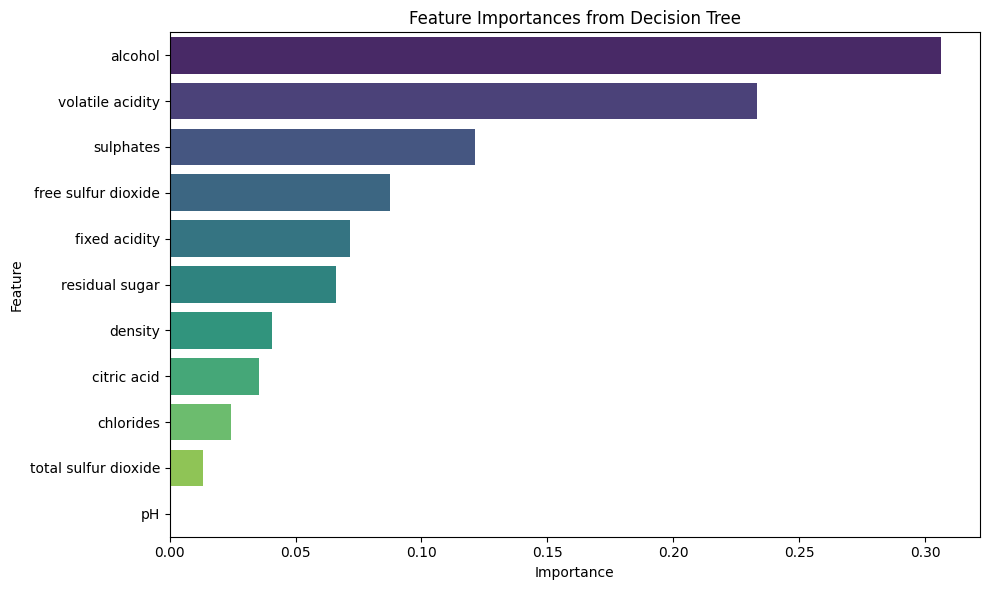

In [120]:
# Deeper tree to get ranked importances
tree_full = DecisionTreeClassifier(max_depth=5, random_state=42)
tree_full.fit(X_train, y_train)

# Feature importance as a sorted DataFrame
feat_importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": tree_full.feature_importances_
}).sort_values(by="Importance", ascending=False)

print(feat_importances)

# Use Data Wrangeling to plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_importances, x="Importance", y="Feature", palette="viridis")
plt.title("Feature Importances from Decision Tree")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "feature_importances_decision_tree.png"))
plt.show()


